In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [28]:
Fs = 500
t0 = 1
dur            = np.zeros((1,2), dtype=np.int32)
t0 = 1
dur[0,0] =  -t0
dur[0,1] =  3
x_ax           = np.arange(dur[0,0],dur[0,1],(1/Fs))

cond_labels = ['BM', 'BL', 'Fuma', 'Benzo']
cond_colors = ['594157', '#594157', "#F1BF98","#8FB996"]

plt.rcParams.update({
    'font.family': 'arial',
    'font.size': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 9,
    'svg.fonttype': 'none',
    'font.size': 10,
    'axes.titlesize': 10,
    'axes.labelsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 9,
    'figure.titlesize': 10
})

def load_data(path, subj):
    #stimlist = pd.read_csv(path_patient_analysis + '/InputOutput/Ph/data/stimlist_Ph.csv')
    lbls = pd.read_excel(os.path.join(path, subj + "_labels.xlsx"), header=0, sheet_name='BP')
    labels = lbls.label.values
    # reading for each connection and stimulation trials the corresponding LL value
    file = os.path.join(path,subj +'_con_trial.csv')
    con_trial = pd.read_csv(file)
    EEG_resp = np.load(os.path.join(path, subj +'_EEG_Ph.npy'))

    return EEG_resp, con_trial, labels

def get_LL_all(data, Fs= 500, win=0.25):
    ## LL for entire signal
    wdp = np.int64(Fs * win)  # 100ms -> 50 sample points
    EEG_pad = np.pad(data, [(0, 0), (0, 0), (np.int64(wdp / 2), np.int64(wdp / 2))], 'constant',
                     constant_values=(0, 0))  # 'reflect'(18, 3006)
    LL_trial = np.zeros((data.shape[0], data.shape[1], data.shape[2]))
    # LL_max = np.zeros((data.shape[0], data.shape[1], 2))
    for i in range(data.shape[2]):  # entire response
        n = i + np.int64(wdp / 2)
        LL_trial[:, :, i] = np.nansum(abs(np.diff(EEG_pad[:, :, n - np.int64(wdp / 2):n + np.int64(wdp / 2)], axis=-1)),
                                      axis=-1) / (win * 1000)
    # onset in ms after probing pulse, must be at least 10ms + half of the sliding window to not include fake data
    return LL_trial

def plot_CCEP_LL(sc, rc, con_trial, EEG_resp, cond = 1, w=0.25):
    Int_all = np.unique(con_trial.Int)
    # get color-code
    divnorm = matplotlib.colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=1.6)
    color_code = plt.cm.hot(divnorm(Int_all / np.max(Int_all)))

    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    # for ix_cond, cond in enumerate(conditions):
    for Int, i in zip(Int_all, np.arange(len(Int_all))):
        dat = con_trial[
            (con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Condition == cond) & (con_trial.Int == Int)]
        StimNum = dat.Num.values.astype('int')
        # data
        signal = EEG_resp[rc, StimNum, :]
        mn = np.mean(signal, 0)
        LL = get_LL_all(np.expand_dims(mn, axis=(0,1)), Fs, w)[0,0]
        LL_max = np.max(LL[int((t0+w/2)*Fs):int((t0+0.5+w/2)*Fs)])
        # 1. plot mean CCEP

        axes[0].plot(x_ax, mn, color=color_code[i], linewidth=2)
        if i == 0:
            axes[0].set_ylabel(cond_labels[cond])
        axes[0].set_title('Mean CCEP')
        axes[1].set_title('LL of Mean CCEP')
        axes[2].set_title('Max LL of Mean CCEP')
        # 2. Plot LL transform
        axes[1].plot(x_ax+w/2, LL, color=color_code[i], linewidth=2)
        # 3. plot LL value
        # todo; decide whether yticks should be intensity or equal space
        # axes[2].plot([0, LL_max], [-i, -i], color=color_code[i], linewidth=3)
        axes[2].plot([0, LL_max], [-Int, -Int], color=color_code[i], linewidth=3)
    # axes[ix_cond, 2].set_xlim([0, 20])
    for k in range(2):
        axes[k].set_xlim([-0.25, 0.5])
        axes[k].set_xlabel('Time [s]')
        axes[k].axvline(0, color='k')
    axes[2].set_xlabel('Max LL [uV/ms]')
    axes[2].set_ylabel('Int [mA]')
    axes[0].set_ylabel('[uV]')
    axes[1].set_ylabel('[uV/ms]')
    return fig, axes


def plot_CCEP_IO(sc, rc, con_trial, EEG_resp, Int_all=[2], conditions=[1, 3], ylim = 600):
    """
        Plots mean CCEP responses for selected stimulation intensities and conditions, alongside an IO curve.

        Parameters:
        - sc: Stimulus channel
        - rc: Response channel
        - con_trial: DataFrame containing trial data
        - EEG_resp: Numpy array containing epoched EEG response data
        - Int_all: List of intensities to plot
        - conditions: List of conditions to plot
        - ylim: limit of y-axis for CCEP plots

        Returns:
        - fig: The figure object containing the plots
        """

    fig, axes = plt.subplots(1, len(Int_all) + 1, figsize=(3 * len(Int_all) + 3, 4))
    # fig, axes = plt.subplots(1, len(Int_all), figsize=(3 * len(Int_all), 4))
    # If there's only one intensity, ensure 'axes' is iterable
    if len(Int_all) == 1:
        axes = [axes]
    io_ax = axes[-1]
    for ix, Int_sel in enumerate(Int_all):
        ax = axes[ix]  # Current axis
        for cond in conditions:
            dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Condition == cond) & (
                        con_trial.Int == Int_sel)]
            StimNum = dat.Num.values.astype('int')
            mn = np.mean(EEG_resp[rc, StimNum, :], 0)
            st = np.std(EEG_resp[rc, StimNum, :], 0)
            ax.plot(x_ax, mn, color=cond_colors[cond], linewidth=2,
                          label=cond_labels[cond] + ', n: ' + str(len(dat)))
            ax.fill_between(x_ax, mn - st, mn + st, color=cond_colors[cond], alpha=0.1)
        ax.set_xlim([-0.25, 0.5])
        ax.set_ylim([-ylim, ylim])
        ax.axvline(0, color=[0, 0, 0])
        ax.axvline(0.25, color=[0, 0, 0], linestyle='--')
        ax.legend()
        ax.set_title('Mean CCEP of stim. Intensity ' + str(Int_sel) + 'mA')

        if ix == 0:
            ax.set_ylabel('[\u03BC V]')
        ax.set_xlabel('time [ms]')
        io_ax.axvline(Int_sel, color=[0, 0, 0], alpha=0.2)

    # IO curve

    dat = con_trial[
        (con_trial.Stim == sc) & (con_trial.Chan == rc) & np.isin(con_trial.Condition, conditions)].reset_index(
        drop=True)
    sns.lineplot(x='Int', y='LL', hue='Condition', data=dat, palette=['#594157', '#8FB996'], linewidth=2, ax=io_ax)
    io_ax.set_ylabel('LL [\u03BC V]')
    io_ax.set_xlabel('Int [mA]')
    io_ax.legend(['BL', 'BZD'])
    io_ax.set_title('IO Curve')

    return fig, axes

## Loading data for selected patient

In [29]:
path_general = 'Human_data/'
subj ='EL003'
EEG_resp, con_trial, labels_all = load_data(path_general, subj)

general parameters used in these figures

In [30]:
cond_labels = ['BM', 'BL', 'Fuma', 'Benzo']
cond_colors = ['594157', '#594157', "#F1BF98","#8FB996"]
Fs = 500
t0 = 1
dur            = np.zeros((1,2), dtype=np.int32)
t0 = 1
dur[0,0] =  -t0
dur[0,1] =  3
x_ax           = np.arange(dur[0,0],dur[0,1],(1/Fs))

### Plot CCEP and LL

Plot mean CCEP and corresponding LL transform for a given connection and condition

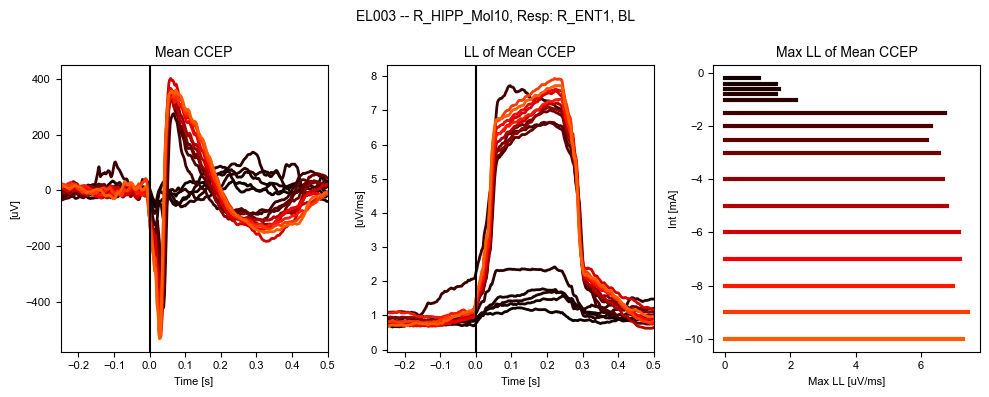

In [31]:
# select Stim channel (sc), response channel (rc) and Condition (cond)
sc = 9
rc = 0
cond = 1 # 1: BL, 3: BZD

fig, axes = plot_CCEP_LL(sc, rc, con_trial, EEG_resp, cond= cond, w=0.25)
plt.suptitle(subj+' -- '+labels_all[sc]+', Resp: '+labels_all[rc]+', '+cond_labels[cond])
plt.tight_layout()
plt.show()

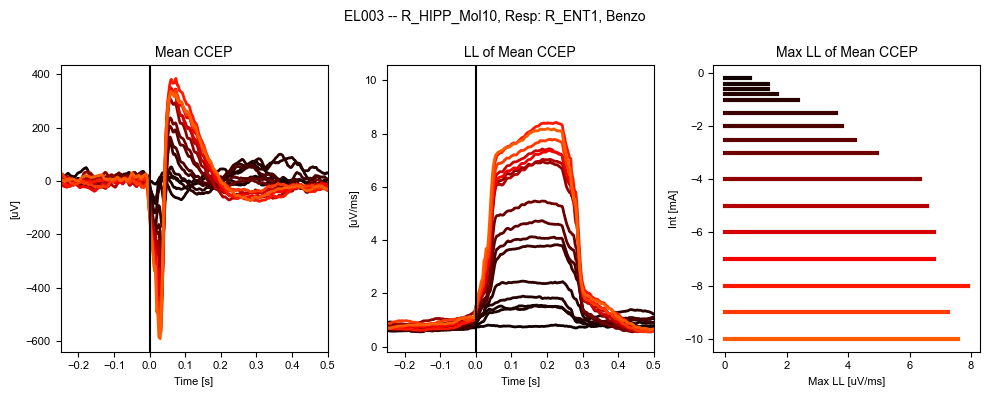

In [32]:
cond = 3 # 1: BL, 3: BZD

fig, axes = plot_CCEP_LL(sc, rc, con_trial, EEG_resp, cond= cond, w=0.25)
plt.suptitle(subj+' -- '+labels_all[sc]+', Resp: '+labels_all[rc]+', '+cond_labels[cond])
plt.tight_layout()
plt.show()

## Plot CCEP and AUC for both conditions

Select for what Intensities the mean CCEP should be plotte (Int_all). Conditons should be  [1, 3] to plot BL and BZD. The IO curve across all intensities is plottted in the last subplot

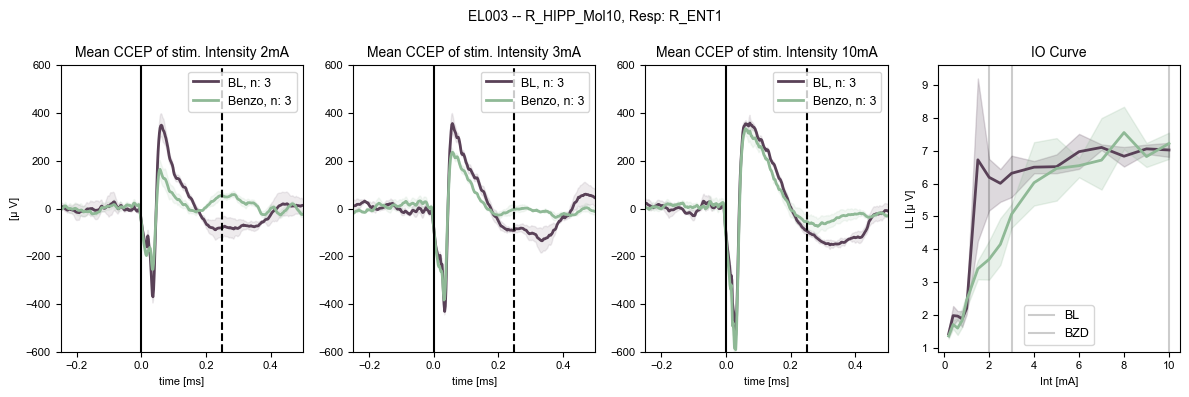

In [33]:
# select intensities to plot (array)
int_sel = [2, 3, 10] # [2]

fig = plot_CCEP_IO(sc, rc, con_trial, EEG_resp, Int_all =int_sel, conditions = [1, 3], ylim = 600)
plt.suptitle(subj+' -- '+labels_all[sc]+', Resp: '+labels_all[rc])
plt.tight_layout()
plt.show()